# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

The notebook pulls data from the John Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases, and then does the following things:

- List total number of confirmed cases (in countries with at least 100 cases)
- Attempt to fit the time series of confirmed cases in these countries to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of confirmed cases to double)
- If the curve fit was successful, summarize doubling times for each country

We then repeat the following steps for the US:
- List total number of confirmed cases by US state & list US locations with the most cases
- Attempt to fit the time series of confirmed US cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of confirmed cases to double)
- If the curve fit was successful, summarize doubling times for each US state with at least 50 cases

The main conclusion is that the doubling time of confirmed cases for countries with many cases is generally on the order of 2 days.

The notebook is updated every evening Eastern Time.

## Important Caveats:
- This analysis uses data on the confirmed cases as reported by countries, which is lower than the actual number of cases in each country.
- Confirmed cases and actual cases in the population grow at different rates. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as fast. So the doubling time for confirmed cases is not the same as the doubling time for actual cases.
- Since we're using the entire timeline to infer the doubling times, these are not the current or most recent doubling times. Instead, for countries where the growth is exponential, the inferred doubling time is indicative of the overall rate of growth.
- For countries where the growth is no longer exponential and the number of cases is stabilizing (such as Mainland China), we fit the growth curve to a logistic function. Here, the inferred doubling time represents the growth encountered during the initial exponential stage of the epidemic (i.e., in the past).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [3]:
for index, row in df.iterrows():
    if row['Country/Region'] == 'Others':
        a = row['Province/State']
        df.loc[index, 'Country/Region'] = a

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/8/20


,3/8/20
Country/Region,
Mainland China,80699
Italy,7375
South Korea,7314
Iran,6566
France,1126
Germany,1040
Diamond Princess cruise ship,696
Spain,673
US,537


## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.9:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit **\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.9:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Curve Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' COVID-19 Cases as of '+mostrecentdate, fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror]
        else:
            return [edoubletime, edoubletimeerror]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror]



Mainland China

** Based on Logistic Fit **

	R^2: 0.994352288328
	Doubling Time:  3.23 (± 0.33 ) days


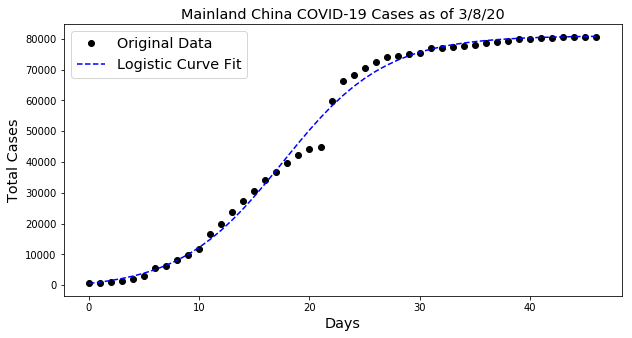



Italy

** Based on Logistic Fit **

	R^2: 0.998423888254
	Doubling Time:  2.69 (± 0.22 ) days

** Based on Exponential Curve Fit **

	R^2: 0.997789690054
	Doubling Time:  3.11 (± 0.1 ) days


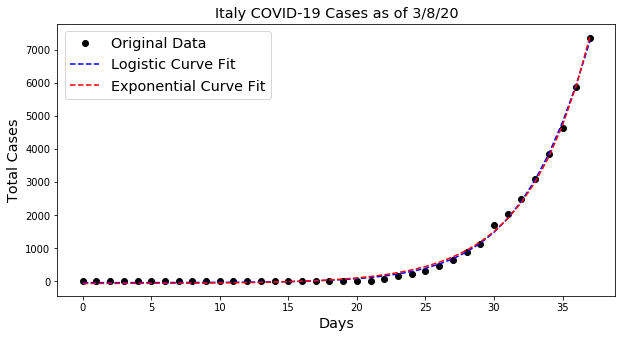



South Korea

** Based on Logistic Fit **

	R^2: 0.999382763482
	Doubling Time:  1.94 (± 0.07 ) days

** Based on Exponential Curve Fit **

	R^2: 0.965848511918
	Doubling Time:  4.92 (± 0.61 ) days


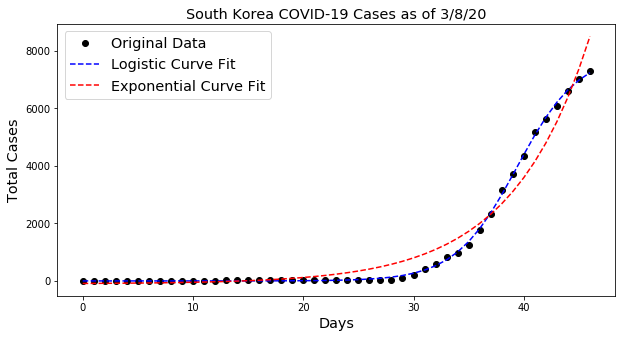



Iran

** Based on Logistic Fit **

	R^2: 0.998059084878
	Doubling Time:  1.64 (± 0.2 ) days

** Based on Exponential Curve Fit **

	R^2: 0.984991200644
	Doubling Time:  2.85 (± 0.44 ) days


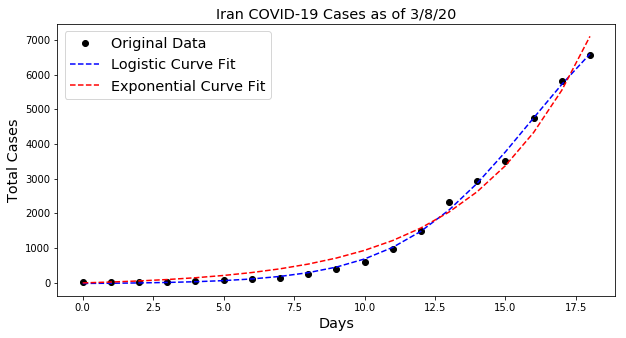



France

** Based on Exponential Curve Fit **

	R^2: 0.99104070431
	Doubling Time:  2.09 (± 0.12 ) days


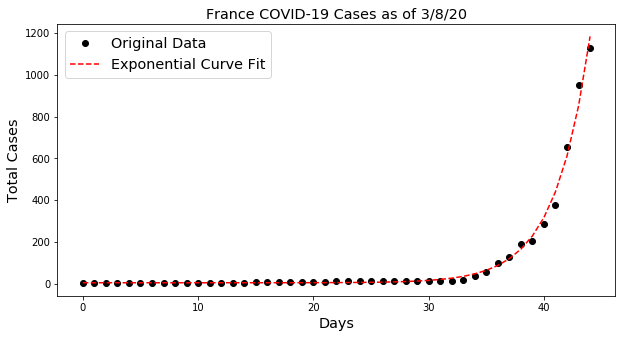



Germany

** Based on Exponential Curve Fit **

	R^2: 0.991068535769
	Doubling Time:  2.23 (± 0.14 ) days


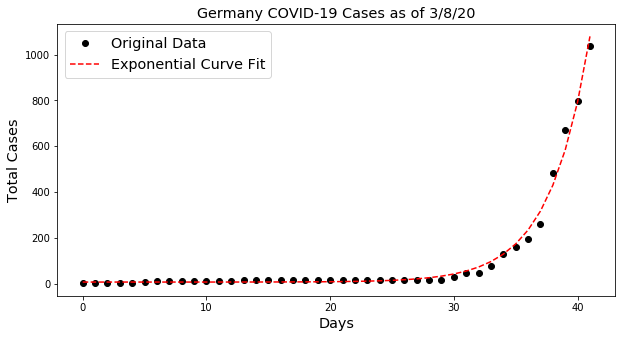



Diamond Princess cruise ship

** Based on Logistic Fit **

	R^2: 0.995217275617
	Doubling Time:  1.36 (± 0.17 ) days


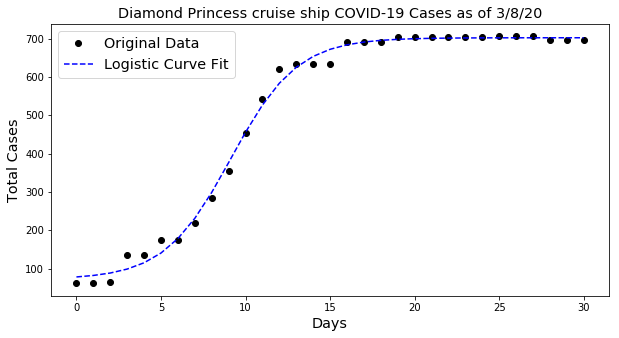



Spain

** Based on Exponential Curve Fit **

	R^2: 0.996605397248
	Doubling Time:  2.34 (± 0.1 ) days


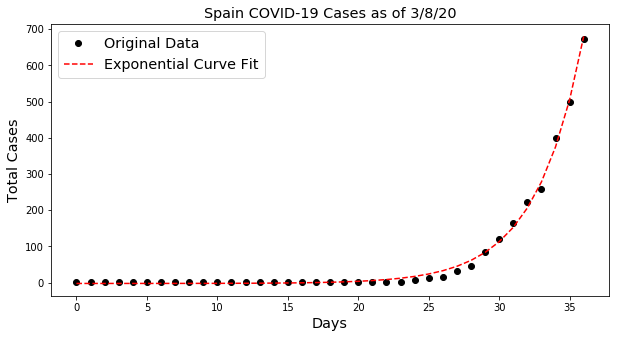



US

** Based on Exponential Curve Fit **

	R^2: 0.988680682362
	Doubling Time:  2.34 (± 0.15 ) days


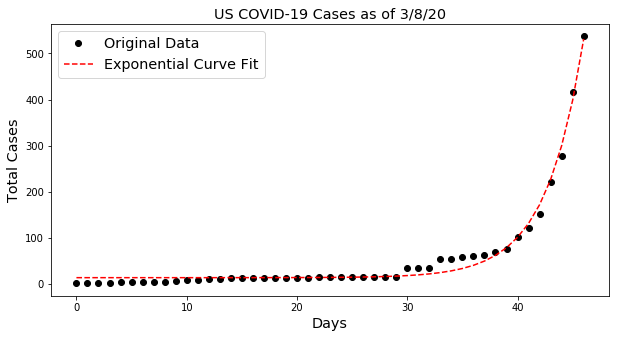



Japan

** Based on Logistic Fit **

	R^2: 0.994166786246
	Doubling Time:  6.77 (± 1.31 ) days

** Based on Exponential Curve Fit **

	R^2: 0.994036208674
	Doubling Time:  7.47 (± 0.43 ) days


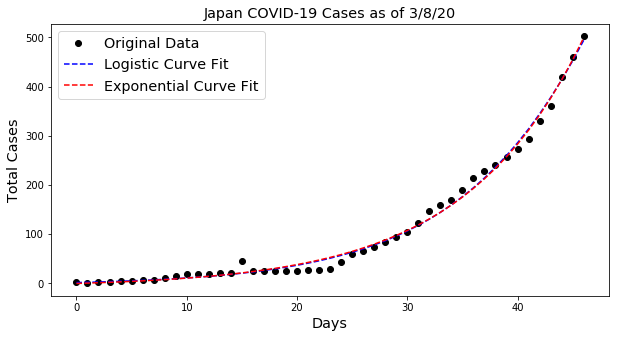



Switzerland

** Based on Logistic Fit **

	R^2: 0.99416795559
	Doubling Time:  1.24 (± 0.37 ) days

** Based on Exponential Curve Fit **

	R^2: 0.988398626041
	Doubling Time:  2.3 (± 0.42 ) days


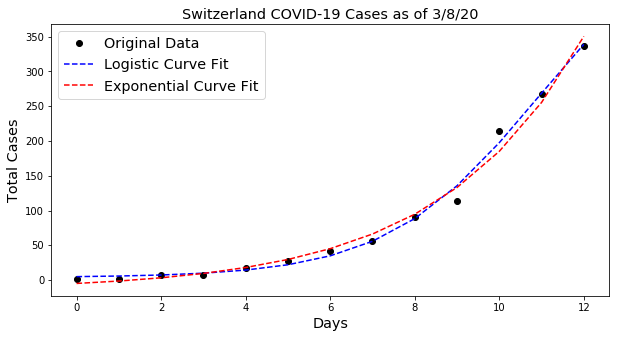



UK

** Based on Exponential Curve Fit **

	R^2: 0.995496459773
	Doubling Time:  2.21 (± 0.1 ) days


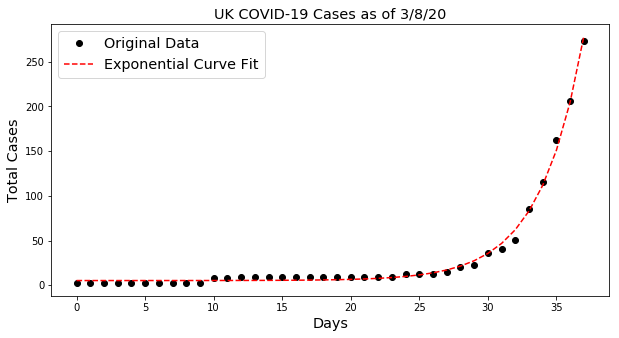



Netherlands

** Based on Logistic Fit **

	R^2: 0.998588261245
	Doubling Time:  1.11 (± 0.2 ) days

** Based on Exponential Curve Fit **

	R^2: 0.994997945272
	Doubling Time:  1.81 (± 0.24 ) days


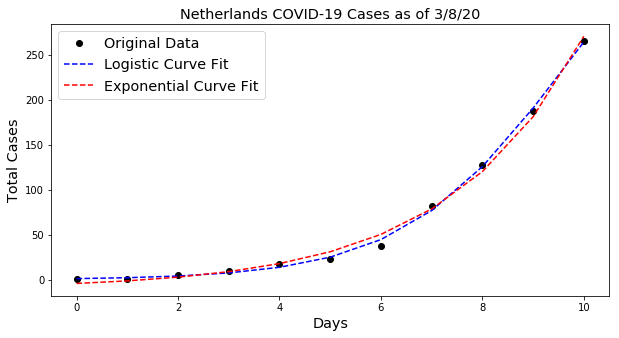



Sweden

** Based on Exponential Curve Fit **

	R^2: 0.982928273763
	Doubling Time:  1.89 (± 0.17 ) days


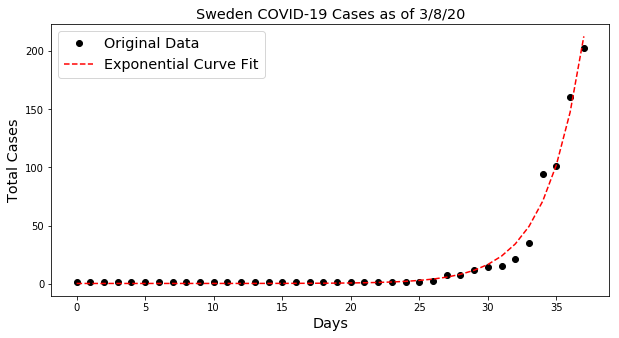



Belgium

** Based on Exponential Curve Fit **

	R^2: 0.971871696966
	Doubling Time:  1.61 (± 0.2 ) days


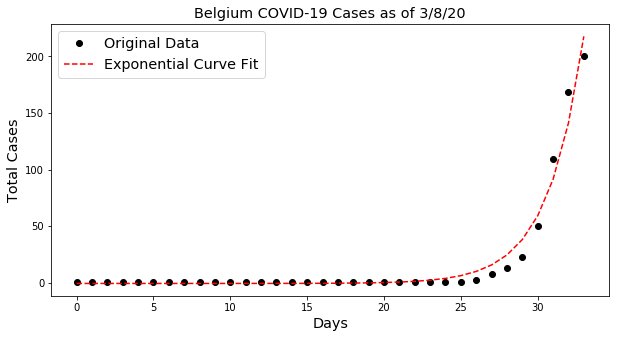



Norway

** Based on Logistic Fit **

	R^2: 0.996663557342
	Doubling Time:  1.43 (± 0.38 ) days

** Based on Exponential Curve Fit **

	R^2: 0.991794800294
	Doubling Time:  2.84 (± 0.55 ) days


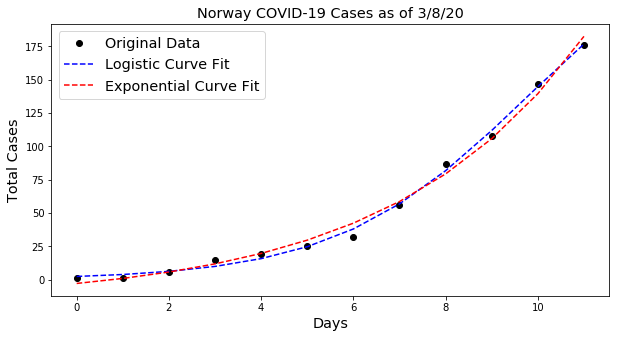



Singapore

** Based on Logistic Fit **

	R^2: 0.977583597535
	Doubling Time:  16.66 (± 21.33 ) days

** Based on Exponential Curve Fit **

	R^2: 0.970441058548
	Doubling Time:  35.68 (± 16.56 ) days


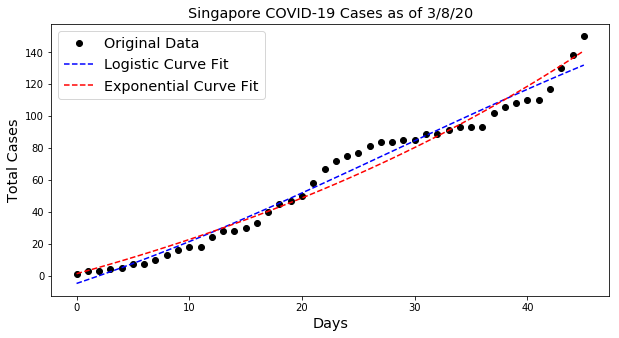



Hong Kong

** Based on Logistic Fit **

	R^2: 0.991699889535
	Doubling Time:  7.43 (± 1.64 ) days

** Based on Exponential Curve Fit **

	R^2: 0.981547565272
	Doubling Time:  39.34 (± 15.74 ) days


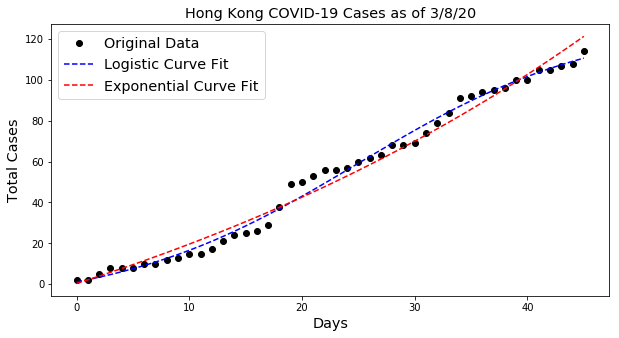



Austria

** Based on Logistic Fit **

	R^2: 0.997650038075
	Doubling Time:  2.29 (± 0.93 ) days

** Based on Exponential Curve Fit **

	R^2: 0.997650038175
	Doubling Time:  2.29 (± 0.19 ) days


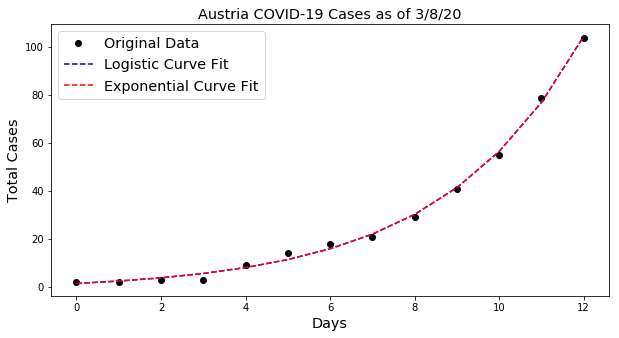

In [6]:
topcountries = cases.index
doublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for Global COVID-19 Cases

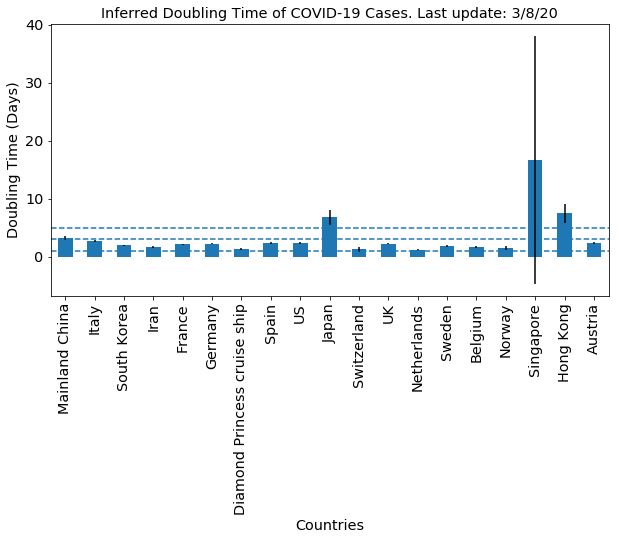

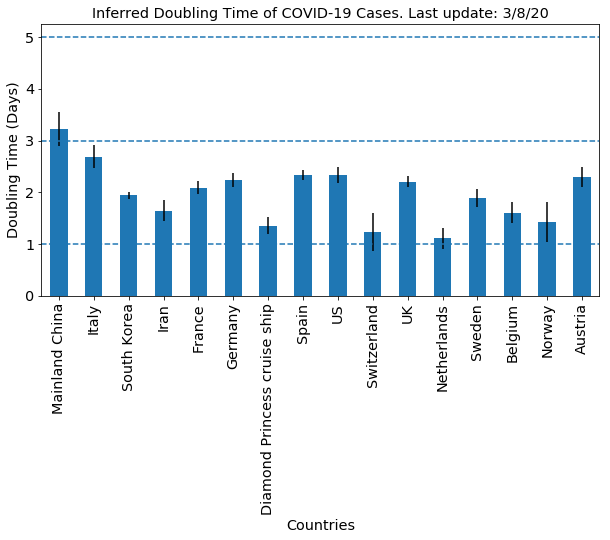

In [7]:
d = {'Countries': countries, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [8]:
uscases = df[df['Country/Region'] == 'US']

uscasesbystate = uscases.copy()
uscasesbystate['Province/State'] = uscasesbystate['Province/State'].str.split(", ", expand=True)[1]

usstatesummary = uscasesbystate.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/8/20


,3/8/20
Province/State,
WA,128
NY,106
CA,98
MA,24
TX,12
OR,12
FL,11
CO,8
IL,7


In [9]:
uscitysummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = uscitysummary.columns[0]
uscitysummary = uscitysummary.sort_values(by = mostrecentdate, ascending = False)
uscitysummary = uscitysummary[uscitysummary[mostrecentdate] >= 5]

print('\nUS Locations with 5 or more confirmed cases as of', mostrecentdate)

uscitysummary


US Locations with 5 or more confirmed cases as of 3/8/20


,3/8/20
Province/State,
"Westchester County, NY",83
"King County, WA",83
Unassigned Location (From Diamond Princess),45
"Santa Clara County, CA",38
"Snohomish County, WA",31
Grand Princess Cruise Ship,21
"Los Angeles, CA",14
"New York County, NY",12
"Contra Costa County, CA",12


## Curve Fitting US COVID-19 Cases



US state:  WA

** Based on Exponential Curve Fit **

	R^2: 0.982634875535
	Doubling Time:  2.3 (± 0.19 ) days


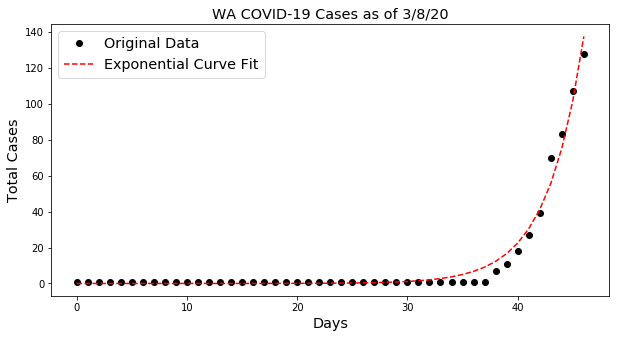



US state:  NY

** Based on Logistic Fit **

	R^2: 0.994436997138
	Doubling Time:  0.78 (± 0.44 ) days

** Based on Exponential Curve Fit **

	R^2: 0.989042259529
	Doubling Time:  1.71 (± 0.61 ) days


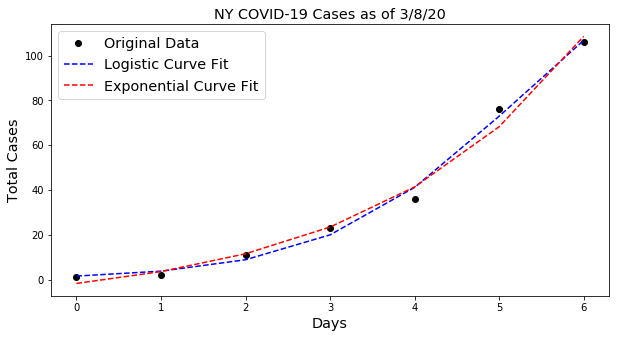



US state:  CA

** Based on Exponential Curve Fit **

	R^2: 0.984325381916
	Doubling Time:  2.38 (± 0.19 ) days


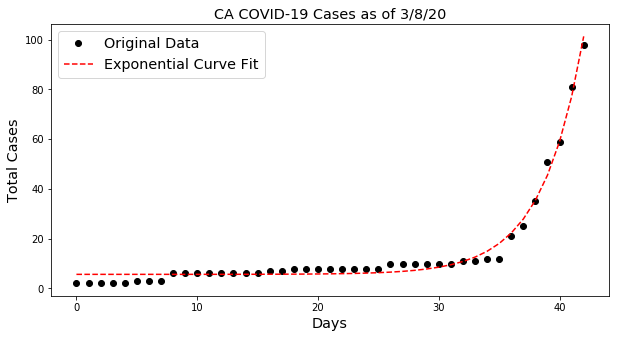

In [10]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 50]
print('\n');
doublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscasesbystate,'Province/State', state)
    if a:
        states.append(state)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for US COVID-19 Cases

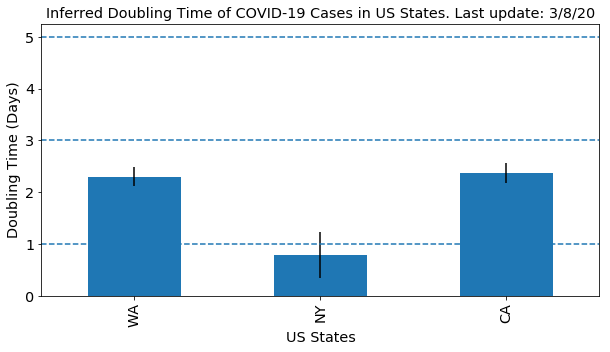

In [11]:
d = {'States': states, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'States', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()
